# Problem Statement:

Your Client FinMan is a financial services company that provides various financial services like loan, investment funds, insurance etc. to its customers. FinMan wishes to cross-sell health insurance to the existing customers who may or may not hold insurance policies with the company. The company recommend health insurance to it's customers based on their profile once these customers land on the website. Customers might browse the recommended health insurance policy and consequently fill up a form to apply. When these customers fill-up the form, their Response towards the policy is considered positive and they are classified as a lead.

Once these leads are acquired, the sales advisors approach them to convert and thus the company can sell proposed health insurance to these leads in a more efficient manner.

Now the company needs your help in building a model to predict whether the person will be interested in their proposed Health plan/policy given the information about:

Demographics (city, age, region etc.)
Information regarding holding policies of the customer
Recommended Policy Information

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
#For visualization
import seaborn as sns
import matplotlib.pyplot as plt
# the scaler - for min-max scaling
from sklearn.preprocessing import RobustScaler
#For model building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score,roc_curve
#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Configurations
file_path_train = r'C:\Users\ADMIN\Jobathon\train_Df64byy.csv'
file_path_test = r'C:\Users\ADMIN\Jobathon\test_YCcRUnU.csv'
file_path_SampleSubmission = r'C:\Users\ADMIN\Jobathon\sample_submission_QrCyCoT.csv'

In [3]:
#Read the input files
X_train = pd.read_csv(file_path_train)
X_test = pd.read_csv(file_path_test)
submission = pd.read_csv(file_path_SampleSubmission)

In [4]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,50882.0,25441.500000,14688.512535,1.0,12721.25,25441.5,38161.75,50882.0
Region_Code,50882.0,1732.788707,1424.081652,1.0,523.00,1391.0,2667.00,6194.0
Upper_Age,50882.0,44.856275,17.310271,18.0,28.00,44.0,59.00,75.0
Lower_Age,50882.0,42.738866,17.319375,16.0,27.00,40.0,57.00,75.0
Holding_Policy_Type,30631.0,2.439228,1.025923,1.0,1.00,3.0,3.00,4.0
Reco_Policy_Cat,50882.0,15.115188,6.340663,1.0,12.00,17.0,20.00,22.0
Reco_Policy_Premium,50882.0,14183.950069,6590.074873,2280.0,9248.00,13178.0,18096.00,43350.4
Response,50882.0,0.239947,0.427055,0.0,0.00,0.0,0.00,1.0


Columns 'Region_Code','Holding_Policy_Type' 'Reco_Policy_Cat' and 'Response' are not continuous in nature.Lets convert these dtypes to categorical.

In [5]:
#changing numerical categorical columns into category type object
for col in ['Region_Code', 'Holding_Policy_Type', 'Reco_Policy_Cat','Response']:
    X_train[col] = X_train[col].astype('object')
#Changing the same for X_test
for col in ['Region_Code', 'Holding_Policy_Type', 'Reco_Policy_Cat']:
    X_test[col] = X_test[col].astype('object')

In [6]:
#Getting an overview of data
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  object 
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  object 
 11  Reco_Policy_Cat          50882 non-null  object 
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  object 
dtypes: float64(1), int64(3

Health indicator,Holding_Policy_Duration and Holding_Policy_Type columns have missing values.

# EDA

# Visualization of Continuous Variables

In [7]:
Numerical_columns=X_train.select_dtypes(include='number').columns
Numerical_columns

Index(['ID', 'Upper_Age', 'Lower_Age', 'Reco_Policy_Premium'], dtype='object')

In [8]:
#Dropping the id column as it does not contain any information
Numerical_columns=Numerical_columns.drop('ID')

In [9]:
Numerical_columns

Index(['Upper_Age', 'Lower_Age', 'Reco_Policy_Premium'], dtype='object')

Analysing numerical columns wrt target

In [10]:
#Method to draw stripplot
def bivariate_stripplot(columns,target):
    fig, axes = plt.subplots(2,2, figsize=(20,10)) # Divide the plot into 2 rows, 2 columns
    # Draw the plot in first row second column
    sns.stripplot(ax=axes[0,0],x=target , y = columns[0], data = X_train)
    axes[0,0].set_title(columns[0])
    if len(columns)>1:
        sns.stripplot( ax=axes[0,1],x=target , y = columns[1], data = X_train)
        axes[0,1].set_title(columns[1])
    if len(columns)>2:
        sns.stripplot( ax=axes[1,0],x=target , y = columns[2], data = X_train)
        axes[1,0].set_title(columns[2])
    if len(columns)>3:
        sns.stripplot( ax=axes[1,1],x=target , y = columns[3], data = X_train)
        axes[1,1].set_title(columns[3])

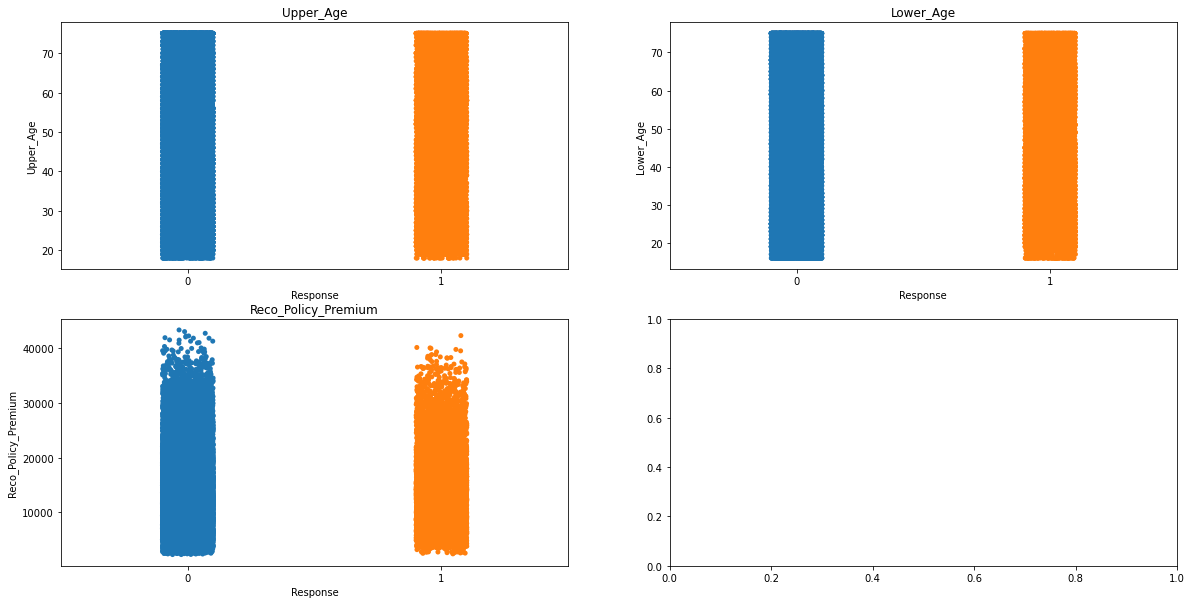

In [11]:
#Drawing the plot for all numerical columns in the dataset
temp=0
length=len(Numerical_columns)
if (length%4 == 0):
    condition=length+1
else:
    condition=(length+(4-(length%4)))+1
for i in range(4,condition,4):
    if i<length:
        bivariate_stripplot(Numerical_columns[temp:i],'Response')
    else:
        bivariate_stripplot(Numerical_columns[temp:length],'Response')
    temp=i

In [12]:
def disc_EqualWidth(customer_data,variable):
    # now let's capture the lower and upper boundaries
    min_value = int(np.floor(customer_data[variable].min()))
    max_value = int(np.ceil(customer_data[variable].max()))
    range_value = max_value - min_value
    # let's round the bin width
    inter_value = int(np.round(range_value/10))
    intervals = [i for i in range(min_value, max_value+inter_value, inter_value)]
    labels = ['Bin_'+str(i) for i in range(1,len(intervals))]
    # create one column with labels
    customer_data[variable+'_disc_label'] = pd.cut(x = customer_data[variable], bins=intervals, labels=labels, include_lowest=True)
    # and one with bin boundaries
    customer_data[variable+'_disc'] = pd.cut(x = customer_data[variable], bins=intervals, include_lowest=True)

In [13]:
#Discretisation of numerical columns
for cols in Numerical_columns:
    disc_EqualWidth(X_train,cols)

In [14]:
#Creating a list of discretised numerical columns
Numerical_columns_disc=Numerical_columns+'_disc'

In [15]:
def bivariate_count(columns,target):
    fig, axes = plt.subplots(2,2, figsize=(20,15)) # Divide the plot into 2 rows, 2 columns
    # Draw the plot in first row second column
    axes[0,0].tick_params('x', labelrotation=90)
    sns.countplot(ax=axes[0,0],x=columns[0], hue=target, data = X_train)
    if len(columns)>1:
        axes[0,1].tick_params('x', labelrotation=90)
        sns.countplot( ax=axes[0,1],x = columns[1],hue=target, data = X_train)
    if len(columns)>2:
        axes[1,0].tick_params('x', labelrotation=90)
        sns.countplot( ax=axes[1,0],x = columns[2],hue=target, data = X_train)
    if len(columns)>3:
        axes[1,1].tick_params('x', labelrotation=90)
        sns.countplot( ax=axes[1,1],x = columns[3],hue=target, data = X_train)

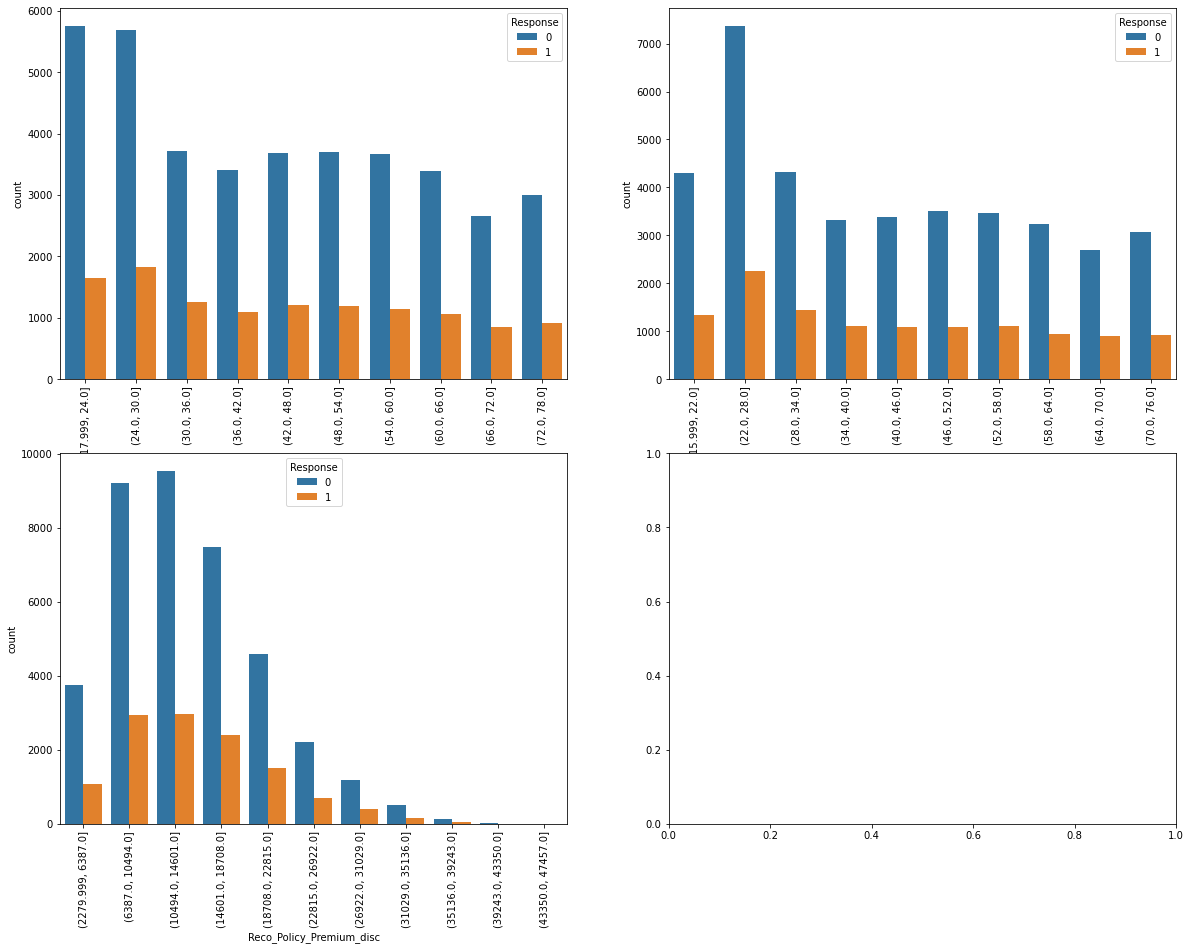

In [16]:
#Drawing a plot for the discretised numeric columns
temp=0
length=len(Numerical_columns_disc)
if (length%4 == 0):
    condition=length+1
else:
    condition=(length+(4-(length%4)))+1
for i in range(4,condition,4):
    if i<length:
        bivariate_count(Numerical_columns_disc[temp:i],'Response')
    else:
        bivariate_count(Numerical_columns_disc[temp:length],'Response')
    temp=i

Proportion of people with response 1 is same in all the age groups for both upper and lower age.'Reco_Policy_Premium' looks like having different impact on different premium groups.Lets reiterate the same with the calculations below.

In [17]:
#Calculating the percentage of people in each category of response.
def calc_perc(colname,target):
    df1=pd.DataFrame(X_train.groupby([colname])[target])
    df1['perc']=0.0
    df1['target_total']=0
    df1['target_yes']=0
    df1['target_no']=0
    for i in range(0,len(df1)):
        df2=df1[1][i]
        total=len(df2)
        if(total==0):
            total=1
        df2=df2[df2==1]
        count_yes=len(df2)
        df1['target_total'][i]=total
        df1['target_yes'][i]=count_yes
        df1['target_no'][i]=total-count_yes
        df1['perc'][i]=(count_yes/total)*100
    df1.rename(columns={0:colname},inplace=True)
    df1=df1.iloc[:,[0,2,3,4,5]]
    df1=df1.sort_values(by='perc',ascending=False)
    return df1

In [18]:
X_train['Response'].value_counts()

0    38673
1    12209
Name: Response, dtype: int64

We dont have the problem of class imbalance here.

In [19]:
for cols in Numerical_columns_disc:
    df1=calc_perc(cols,'Response')
    print(df1)

   Upper_Age_disc       perc  target_total  target_yes  target_no
2    (30.0, 36.0]  25.302176          4964        1256       3708
4    (42.0, 48.0]  24.534860          4891        1200       3691
5    (48.0, 54.0]  24.423116          4897        1196       3701
3    (36.0, 42.0]  24.350721          4505        1097       3408
1    (24.0, 30.0]  24.248470          7518        1823       5695
8    (66.0, 72.0]  24.188034          3510         849       2661
7    (60.0, 66.0]  23.933543          4454        1066       3388
6    (54.0, 60.0]  23.858921          4820        1150       3670
9    (72.0, 78.0]  23.443878          3920         919       3001
0  (17.999, 24.0]  22.328786          7403        1653       5750
   Lower_Age_disc       perc  target_total  target_yes  target_no
3    (34.0, 40.0]  25.090171          4436        1113       3323
8    (64.0, 70.0]  24.930594          3602         898       2704
2    (28.0, 34.0]  24.930411          5748        1433       4315
6    (52.0

From the above observations we can see that 'Upper_Age' and 'Lower_Age' columns have very less or negligible effect on the target.Both these columns have around 22-28 percent of people with the response as 1 across all age groups.
Now lets do equal frequency discretisation of 'Reco_Policy_Premium' column to analyse further.

In [20]:
#Equal frequency discretisation
def disc_EqualFreq(X_train,variable):
    # create 10 labels, one for each quantile
    labels = ['Q'+str(i+1) for i in range(0,10)]
    X_train[variable+'_disc'], bins = pd.qcut(x=X_train[variable], q=10, retbins=True, precision=3, duplicates='drop')
   

In [21]:
disc_EqualFreq(X_train,'Reco_Policy_Premium')

In [22]:
calc_perc('Reco_Policy_Premium_disc','Response')

,Reco_Policy_Premium_disc,perc,target_total,target_yes,target_no
7,"(16980.0, 19432.0]",25.196541,5088,1282,3806
1,"(6480.0, 8400.0]",24.705882,5100,1260,3840
8,"(19432.0, 23167.2]",24.552782,5087,1249,3838
9,"(23167.2, 43350.4]",24.272799,5088,1235,3853
2,"(8400.0, 9996.0]",24.119614,5083,1226,3857
5,"(13178.0, 14976.0]",23.844187,5083,1212,3871
6,"(14976.0, 16980.0]",23.682140,5084,1204,3880
4,"(11502.0, 13178.0]",23.456303,5069,1189,3880
3,"(9996.0, 11502.0]",23.437194,5103,1196,3907
0,"(2279.999, 6480.0]",22.680008,5097,1156,3941


From the above we can see that 'Reco_Policy_Premium' has around 22-25 pecent of people with target 1 in all premium categories.This shows that this column has less impact on the response.

# Visualisation of Categorical Variables.

In [23]:
Categorical_columns=X_train.select_dtypes(include=['category',object]).columns
Categorical_columns

Index(['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration',
       'Holding_Policy_Type', 'Reco_Policy_Cat', 'Response',
       'Upper_Age_disc_label', 'Upper_Age_disc', 'Lower_Age_disc_label',
       'Lower_Age_disc', 'Reco_Policy_Premium_disc_label',
       'Reco_Policy_Premium_disc'],
      dtype='object')

Lets remove the 'Response' column and other manually inserted columns from the above list.

In [24]:
Categorical_columns=Categorical_columns.drop(['Response',
       'Upper_Age_disc_label', 'Upper_Age_disc', 'Lower_Age_disc_label',
       'Lower_Age_disc', 'Reco_Policy_Premium_disc_label',
       'Reco_Policy_Premium_disc','Region_Code'])

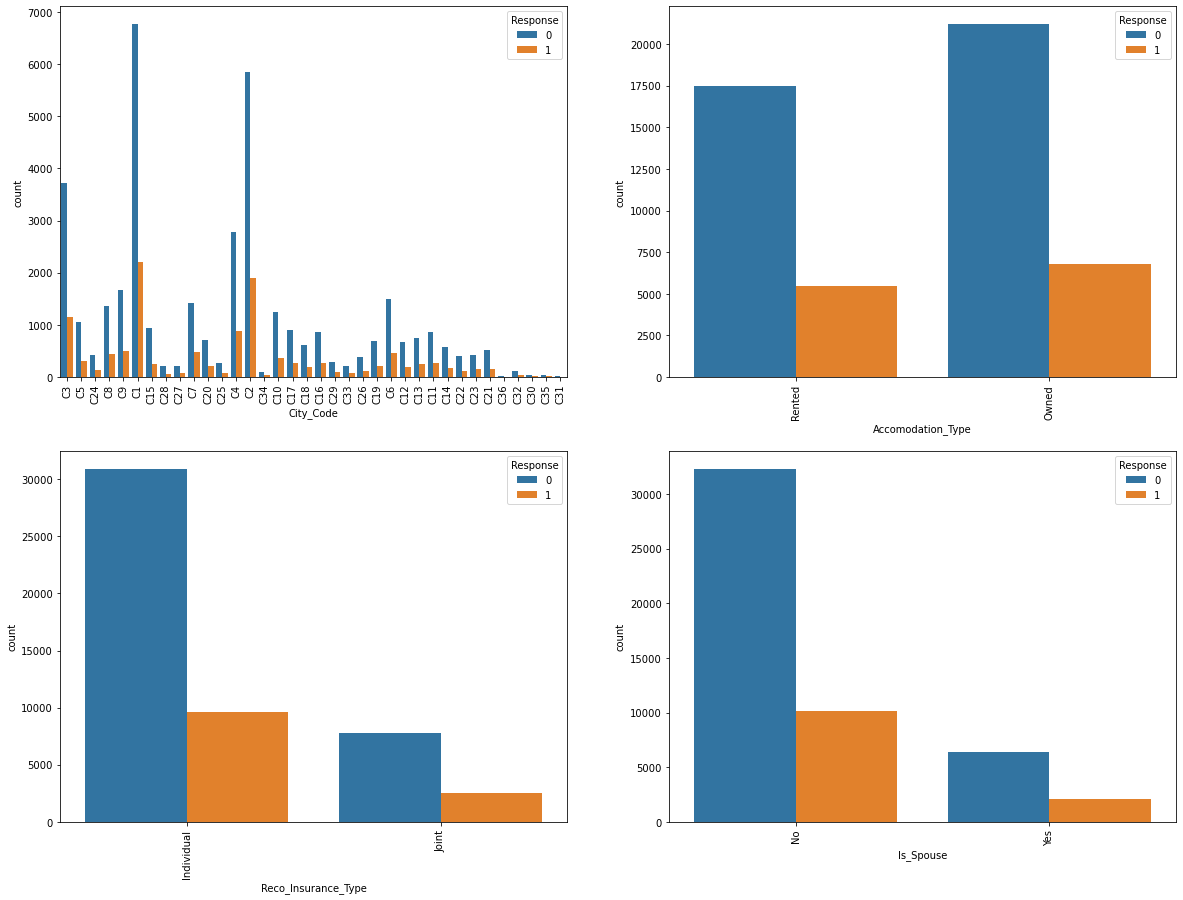

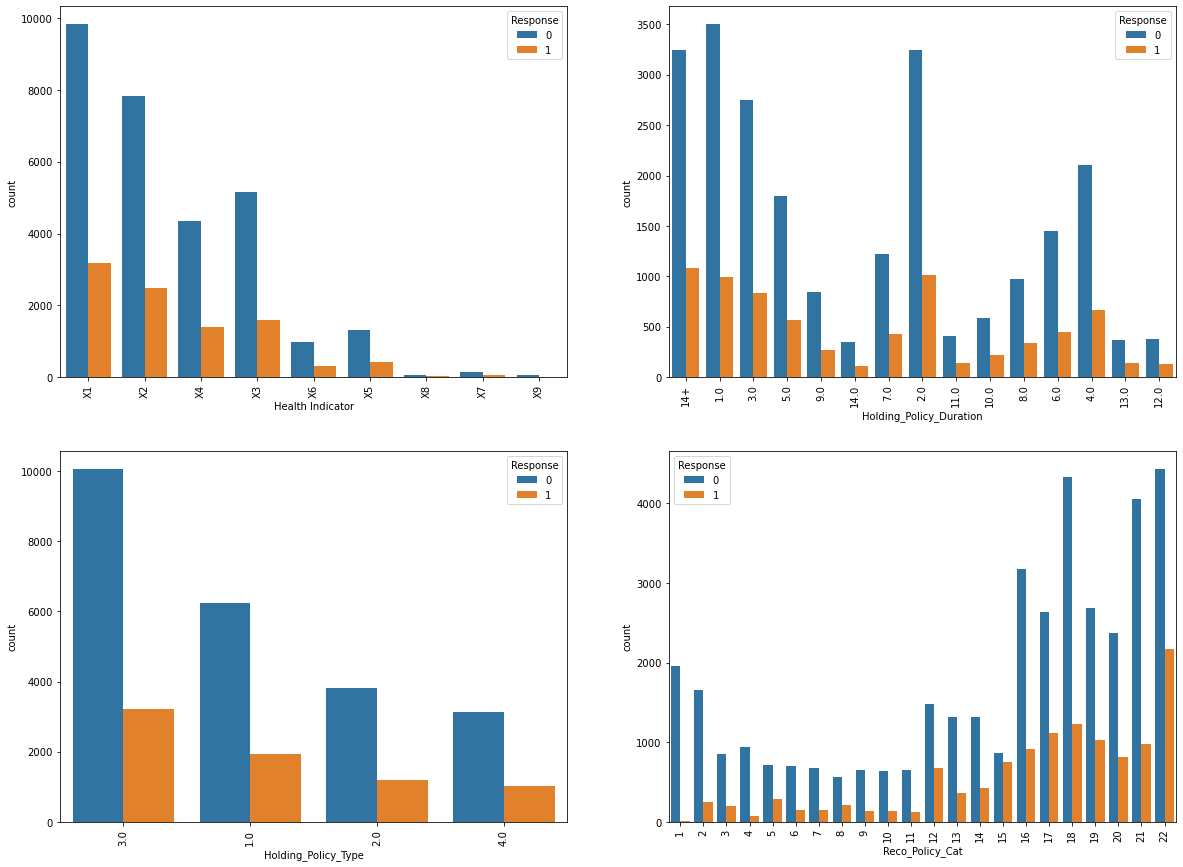

In [25]:
#plotting count plot for all categorical columns.
temp=0
length=len(Categorical_columns)
if (length%4 == 0):
    condition=length+1
else:
    condition=(length+(4-(length%4)))+1
for i in range(4,condition,4):
    if i<length:
        bivariate_count(Categorical_columns[temp:i],'Response')
    else:
        bivariate_count(Categorical_columns[temp:len(Categorical_columns)],'Response')
    temp=i

In [26]:
#Now lets calculate the percentage of people for each of these categorical columns.
calc_perc(Categorical_columns[0],'Response')

,City_Code,perc,target_total,target_yes,target_no
23,C30,31.034483,58,18,40
25,C32,28.750000,160,46,114
28,C35,28.571429,56,16,40
27,C34,27.692308,130,36,94
15,C23,26.575809,587,156,431
19,C27,25.762712,295,76,219
4,C13,25.373134,1005,255,750
33,C7,25.340314,1910,484,1426
26,C33,24.825175,286,71,215
0,C1,24.607155,8973,2208,6765


Cities C31 and C36 have equal and less percentage of people with response as 1.
City C30 has the highest percentage of people(around 30%) with response as 1.

In [27]:
calc_perc(Categorical_columns[1],'Response')

,Accomodation_Type,perc,target_total,target_yes,target_no
0,Owned,24.195914,27951,6763,21188
1,Rented,23.749509,22931,5446,17485


Both accomodation types have same percent of people with response as 1.

In [28]:
calc_perc(Categorical_columns[2],'Response')

,Reco_Insurance_Type,perc,target_total,target_yes,target_no
1,Joint,24.830853,10346,2569,7777
0,Individual,23.781330,40536,9640,30896


Both recommended insurance types have same percent of people with response as 1.

In [29]:
calc_perc(Categorical_columns[3],'Response')

,Is_Spouse,perc,target_total,target_yes,target_no
1,Yes,24.364759,8422,2052,6370
0,No,23.921338,42460,10157,32303


Both 'Is_Spouse' types have same percent of people with response as 1.

In [30]:
calc_perc(Categorical_columns[4],'Response')

,Health Indicator,perc,target_total,target_yes,target_no
6,X7,31.632653,196,62,134
0,X1,24.411991,13010,3176,9834
3,X4,24.307853,5743,1396,4347
1,X2,24.109563,10332,2491,7841
5,X6,23.984375,1280,307,973
2,X3,23.646850,6762,1599,5163
4,X5,23.624783,1727,408,1319
7,X8,23.076923,78,18,60
8,X9,22.222222,63,14,49


Health Indicator X7 has highest percent of people(around 32) with response as 1.
Whereas other health indicators have around 22-24 percent of people with response as 1.

Lets do zero encoding for 'Holding_Policy_Duration' and 'Holding_Policy_Type' columns.As blanks in these two columns essentially indicate that the customer does not hold any policy currently.

In [31]:
X_train['Holding_Policy_Duration']=X_train['Holding_Policy_Duration'].fillna('0.0')
X_test['Holding_Policy_Duration']=X_test['Holding_Policy_Duration'].fillna('0.0')
X_train['Holding_Policy_Type']=X_train['Holding_Policy_Type'].fillna('0.0')
X_test['Holding_Policy_Type']=X_test['Holding_Policy_Type'].fillna('0.0')

In [32]:
calc_perc(Categorical_columns[5],'Response')

,Holding_Policy_Duration,perc,target_total,target_yes,target_no
2,10.0,27.306273,813,222,591
5,13.0,27.005871,511,138,373
13,7.0,25.714286,1645,423,1222
14,8.0,25.683891,1316,338,978
4,12.0,25.341131,513,130,383
3,11.0,25.091575,546,137,409
6,14+,25.074971,4335,1087,3248
7,14.0,24.678112,466,115,351
10,4.0,24.070733,2771,667,2104
0,0.0,23.895116,20251,4839,15412


All 'Holding_Policy_Duration' has 22-27 percent of people having the response as 1.

In [33]:
calc_perc(Categorical_columns[6],'Response')

,Holding_Policy_Type,perc,target_total,target_yes,target_no
3,4,24.820316,4174,1036,3138
2,3,24.226222,13279,3217,10062
4,0.0,23.895116,20251,4839,15412
1,2,23.776224,5005,1190,3815
0,1,23.577634,8173,1927,6246


In [34]:
calc_perc(Categorical_columns[7],'Response')

,Reco_Policy_Cat,perc,target_total,target_yes,target_no
14,15,46.563467,1615,752,863
21,22,32.838534,6602,2168,4434
11,12,31.503690,2168,683,1485
16,17,29.845580,3756,1121,2635
4,5,29.096326,1007,293,714
18,19,27.696872,3708,1027,2681
7,8,26.932990,776,209,567
19,20,25.495751,3177,810,2367
13,14,24.397245,1742,425,1317
15,16,22.355534,4084,913,3171


Recommended policy category has impact on the response.Policy category 15 has the highest response with 46 percent.

In [35]:
#Lets indicate a new column that indicates if a customer is currently holding a policy
X_train['CurrentPolicyHolder']=np.where(X_train['Holding_Policy_Duration']=='0.0','0','1')
X_test['CurrentPolicyHolder']=np.where(X_test['Holding_Policy_Duration']=='0.0','0','1')

In [36]:
#Comparing the newly created column with response.
calc_perc('CurrentPolicyHolder','Response')

,CurrentPolicyHolder,perc,target_total,target_yes,target_no
1,1,24.060592,30631,7370,23261
0,0,23.895116,20251,4839,15412


This column also does not add much information to the response variable.

'Reco_Policy_Premium','City_Code','Health Indicator' and 'Reco_Policy_Cat' are the features identified as having significant impact on Response variable.

# Feature Engineering

In [37]:
#Lets add a new column average age which is the average of upper and lower age
X_train['Age_mean'] = X_train.loc[: , ["Upper_Age","Lower_Age"]].mean(axis=1)
X_test['Age_mean'] = X_test.loc[: , ["Upper_Age","Lower_Age"]].mean(axis=1)

In [38]:
#Assigning new train and test based on identified columns.
X_train1=X_train.loc[:,['City_Code','Accomodation_Type','Health Indicator','Reco_Policy_Cat','Reco_Insurance_Type','Upper_Age','Lower_Age','Region_Code','Reco_Policy_Premium','Holding_Policy_Duration','Holding_Policy_Type','Is_Spouse','Age_mean','CurrentPolicyHolder','Response']]
X_test1=X_test.loc[:,['City_Code','Accomodation_Type','Health Indicator','Reco_Policy_Cat','Reco_Insurance_Type','Upper_Age','Lower_Age','Region_Code','Reco_Policy_Premium','Holding_Policy_Duration','Holding_Policy_Type','Is_Spouse','Age_mean','CurrentPolicyHolder']]

In [39]:
X_train1['Health Indicator']=X_train1['Health Indicator'].fillna('Missing')
X_test1['Health Indicator']=X_test1['Health Indicator'].fillna('Missing')

In [40]:
X_train1['Response']=X_train1['Response'].astype('int32')

In [41]:
def rare_new_imputation(X_train,X_test,variable,rare_cat):
    X_train[variable+'_rare_imp'] = np.where(X_train[variable].isin(rare_cat), 'Others', X_train[variable])
    X_test[variable+'_rare_imp'] = np.where(X_test[variable].isin(rare_cat), 'Others', X_test[variable])
    Extra_values_in_test=[]
    #Categories in test set that are not present in train set
    for val_test in X_test[variable+'_rare_imp'].unique():
        val_present=False
        for val_train in X_train[variable+'_rare_imp'].unique():
            if val_test==val_train:
                val_present=True
                break
            if val_present==False:
                Extra_values_in_test.append(val_test)
    X_test[variable+'_rare_imp'] = np.where(X_test[variable+'_rare_imp'].isin(Extra_values_in_test), 'Others', X_test[variable+'_rare_imp'])

In [42]:
temp = X_train1.groupby(['Region_Code'])['Region_Code'].count()/np.float(len(X_train1))
rare_cat = [x for x in temp.loc[temp<0.00005].index.values]
#Creates a new column 'Region_code_rare_imp' with imputed values
rare_new_imputation(X_train1,X_test1,'Region_Code',rare_cat)

In [43]:
Categorical_columns=X_train1.select_dtypes(include=['category',object]).columns
#Dropping the old region code column as we are using the new imputed column from here.
Categorical_columns=Categorical_columns.drop('Region_Code')

In [44]:
def CategoricalImputation_RiskFactor(X_train,X_test,variable,target_variable):
    ordered_labels = X_train.groupby([variable])[target_variable].mean().to_dict()
    X_train[variable+'_ordered'] = X_train[variable].map(ordered_labels)
    X_test[variable+'_ordered'] = X_test[variable].map(ordered_labels)

In [45]:
#Converting all categorical columns to numeric
for cols in Categorical_columns:
     CategoricalImputation_RiskFactor(X_train1,X_test1,cols,'Response')

In [46]:
#Taking only the encoded values for categorical columns
X_train1=X_train1.loc[:,['Reco_Policy_Premium','Upper_Age','Lower_Age','Region_Code_rare_imp_ordered','City_Code_ordered','Accomodation_Type_ordered','Health Indicator_ordered','Reco_Policy_Cat_ordered','Reco_Insurance_Type_ordered','Holding_Policy_Type_ordered','Holding_Policy_Duration_ordered','Is_Spouse_ordered','CurrentPolicyHolder_ordered','Response']]
X_test1=X_test1.loc[:,['Reco_Policy_Premium','Upper_Age','Lower_Age','Region_Code_rare_imp_ordered','City_Code_ordered','Accomodation_Type_ordered','Health Indicator_ordered','Reco_Policy_Cat_ordered','Reco_Insurance_Type_ordered','Holding_Policy_Type_ordered','Holding_Policy_Duration_ordered','Is_Spouse_ordered','CurrentPolicyHolder_ordered']]

In [47]:
#Feature scaling on X_train and X_test
def scaler_Robust(X_train,X_test):
    # set up the scaler
    scaler = RobustScaler()
    # fit the scaler to the train set, it will learn the parameters
    scaler.fit(X_train)
    # transform train and test sets
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # let's transform the returned NumPy arrays to dataframes 
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    return X_train_scaled,X_test_scaled

In [48]:
#this xtrain and xtest will be used for linear algorithms as scaling is necessary
X_train_scaled,X_test_scaled=scaler_Robust(X_train1.iloc[:,0:13],X_test1)

In [49]:
# let's separate into training and testing set

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train1.iloc[:,0:13], X_train1.Response, test_size=0.3,
                                                    random_state=0)
X_train_sub.shape, X_test_sub.shape,y_train_sub.shape,y_test_sub.shape

((35617, 13), (15265, 13), (35617,), (15265,))

In [50]:
# let's separate the scaled data into training and testing set

X_train_sub_scaled, X_test_sub_scaled, y_train_sub_scaled, y_test_sub_scaled = train_test_split(X_train_scaled, X_train1.Response, test_size=0.3,
                                                    random_state=0)
X_train_sub_scaled.shape, X_test_sub_scaled.shape,y_train_sub_scaled.shape,y_test_sub_scaled.shape

((35617, 13), (15265, 13), (35617,), (15265,))

# Modelling

In [51]:
#DT classifier using all the parameters
model_all_features = DecisionTreeClassifier(criterion="gini", max_depth=5)
model_all_features.fit(X_train_sub, y_train_sub)

DecisionTreeClassifier(max_depth=5)

In [52]:
# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict(X_test_sub)
auc_score_all = roc_auc_score(y_test_sub, y_pred_test)
print('Test all features xgb ROC AUC=%f' % (auc_score_all))

Test all features xgb ROC AUC=0.536895


<AxesSubplot:>

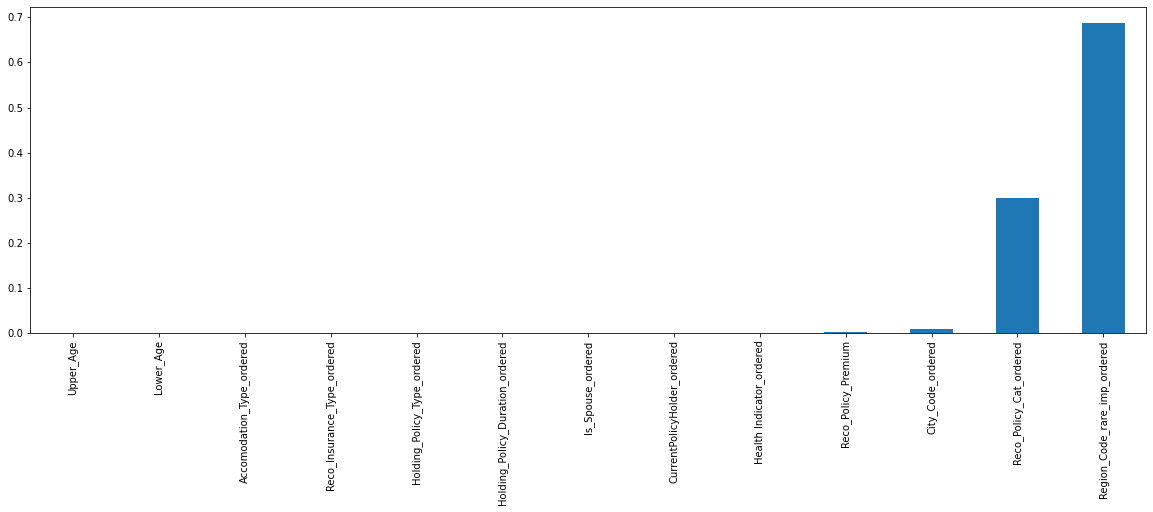

In [53]:
# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train_sub.iloc[:,0:13].columns
# sort the features by importance
features.sort_values(ascending=True, inplace=True)
# plot
features.plot.bar(figsize=(20,6))

In [54]:
#Using random forest classifier
model_o = RandomForestClassifier()
model_o.fit(X_train1.iloc[:,0:13],X_train1.Response)
y_pred=model_o.predict(X_test1)
submission['Response']=y_pred
submission['Response'].value_counts()
submission.to_csv(r'C:\Users\ADMIN\Jobathon\Solution\my_submission_rf.csv', index=False)

<AxesSubplot:>

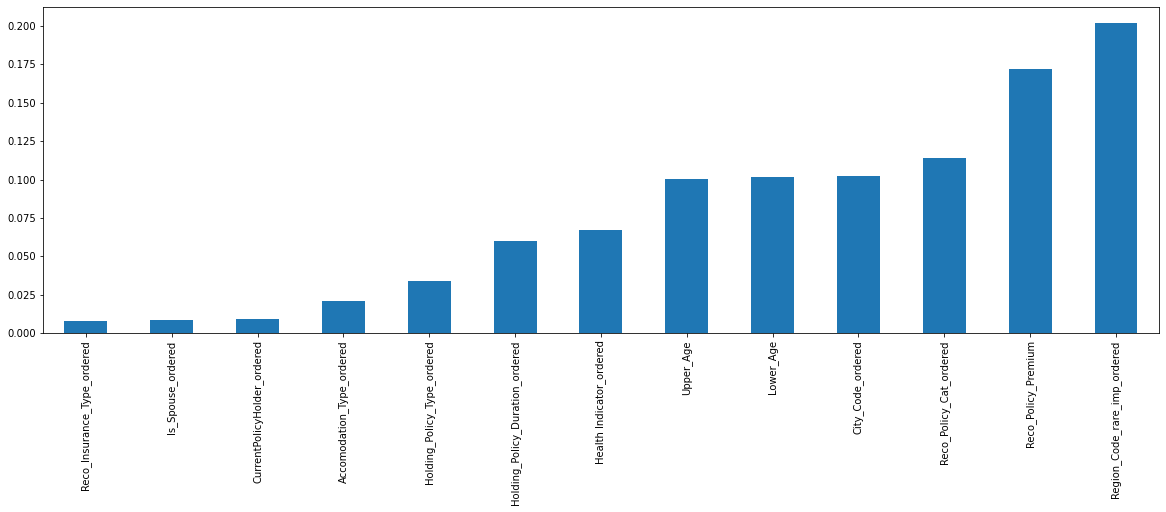

In [55]:
# get feature name and importance
features = pd.Series(model_o.feature_importances_)
features.index = X_train1.iloc[:,0:13].columns
# sort the features by importance
features.sort_values(ascending=True, inplace=True)
# plot
features.plot.bar(figsize=(20,6))

Now,lets try using the thresholds for auc to check if the score improves

Using threshold for logistic regression.

In [56]:
def plot_roc_curve(fpr,tpr):
    plt.plot(fpr,tpr,color='orange',label='ROC')
    plt.plot([0,1],[0,1],color='blue',linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristics (ROC) curve')
    plt.legend()
    plt.show()

In [57]:
classifier=LogisticRegression()
classifier.fit(X_train_sub_scaled,y_train_sub_scaled)
y_pred=classifier.predict_proba(X_test_sub_scaled)[:,1]

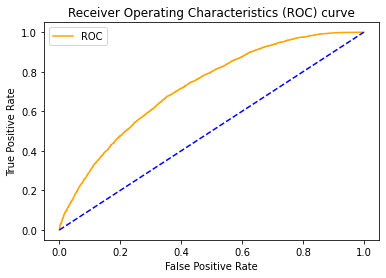

In [58]:
fpr,tpr,thresholds=roc_curve(y_test_sub_scaled,y_pred)
thresholds
#plotting the roc_auc curve
plot_roc_curve(fpr,tpr)

In [59]:
roc_list=[]
for thres in thresholds:
    y_pred1=np.where(y_pred>thres,1,0)
    roc_list.append(roc_auc_score(y_test_sub_scaled,y_pred1))
roc_list=pd.DataFrame(pd.concat([pd.Series(thresholds),pd.Series(roc_list)],axis=1))
roc_list.columns=['threshold','roc']
roc_list.sort_values(by='roc',ascending=False,inplace=True)
roc_list.head()

,threshold,roc
2939,0.227993,0.660695
2940,0.227989,0.660651
2937,0.228002,0.660605
2938,0.227994,0.660562
2960,0.226993,0.660560


Fitting the model with threshold for maximum roc.

In [60]:
#Fitting the model to original test set
classifier.fit(X_train_scaled.iloc[:,0:13],X_train1.Response)
y_pred=classifier.predict_proba(X_test_scaled)[:,1]
#Getting the output using the above threshold giving maximum roc
y_pred1=np.where(y_pred>np.round(roc_list.iloc[0,0],6),1,0)
submission['Response']=y_pred1
submission['Response'].value_counts()
submission.to_csv(r'C:\Users\ADMIN\Jobathon\Solution\my_submission_Lr_usingthreshold_resample.csv', index=False)

Using the threshold for gboost classifier

In [61]:
model_gboost=GradientBoostingClassifier()
model_gboost.fit(X_train_sub,y_train_sub)
y_pred=model_gboost.predict_proba(X_test_sub)[:,1]

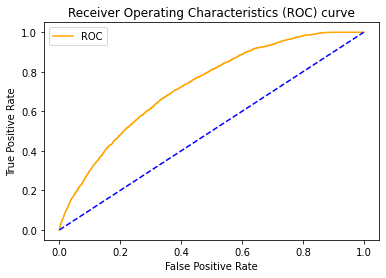

In [62]:
fpr,tpr,thresholds=roc_curve(y_test_sub,y_pred)
thresholds
#plotting the roc_auc curve
plot_roc_curve(fpr,tpr)

In [63]:
roc_list=[]
for thres in thresholds:
    y_pred1=np.where(y_pred>thres,1,0)
    roc_list.append(roc_auc_score(y_test_sub,y_pred1))
roc_list=pd.DataFrame(pd.concat([pd.Series(thresholds),pd.Series(roc_list)],axis=1))
roc_list.columns=['threshold','roc']
roc_list.sort_values(by='roc',ascending=False,inplace=True)
roc_list.head()

,threshold,roc
3289,0.235690,0.664179
3291,0.235649,0.664138
3290,0.235683,0.664135
3287,0.235763,0.664132
3292,0.235562,0.664095


Fitting the model with threshold for maximum roc.

In [64]:
model_gboost.fit(X_train1.iloc[:,0:13],X_train1.Response)
y_pred=model_gboost.predict_proba(X_test1)[:,1]
y_pred1=np.where(y_pred>np.round(roc_list.iloc[0,0],6),1,0)
submission['Response']=y_pred1
submission.to_csv(r'C:\Users\ADMIN\Jobathon\Solution\my_submission_gboost.csv', index=False)

Using a voting classifier.

In [65]:
#parameters use dfor initial upload['City_Code_ordered','Reco_Policy_Premium','Region_Code_rare_imp_ordered','Health Indicator_ordered','Reco_Policy_Cat_ordered','Holding_Policy_Duration_ordered']
estimator = [] 
estimator.append(('LR', LogisticRegression()))
estimator.append(('KNN', KNeighborsClassifier()))
estimator.append(('DT', DecisionTreeClassifier()))
classifier=VotingClassifier(estimators=estimator,voting='soft')
classifier.fit(X_train_sub_scaled,y_train_sub_scaled)
y_pred=classifier.predict_proba(X_test_sub_scaled)[:,1]

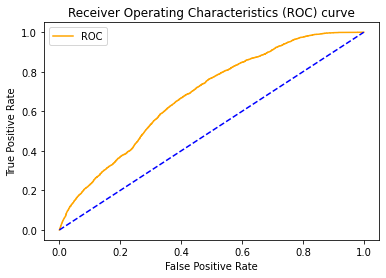

In [66]:
fpr,tpr,thresholds=roc_curve(y_test_sub_scaled,y_pred)
thresholds
#plotting the roc_auc curve
plot_roc_curve(fpr,tpr)

In [67]:
roc_list=[]
for thres in thresholds:
    y_pred1=np.where(y_pred>thres,1,0)
    roc_list.append(roc_auc_score(y_test_sub_scaled,y_pred1))
roc_list=pd.DataFrame(pd.concat([pd.Series(thresholds),pd.Series(roc_list)],axis=1))
roc_list.columns=['threshold','roc']
roc_list.sort_values(by='roc',ascending=False,inplace=True)
roc_list.head()

,threshold,roc
3724,0.142761,0.635854
3720,0.142901,0.635848
3732,0.142401,0.635825
3726,0.142670,0.635814
3725,0.142757,0.635811


Fitting the model with threshold for maximum roc.

In [68]:
#Fitting the model to original test set
classifier.fit(X_train_scaled.iloc[:,0:13],X_train1.Response)
y_pred=classifier.predict_proba(X_test_scaled)[:,1]
#Getting the output using the above threshold giving maximum roc
y_pred1=np.where(y_pred>np.round(roc_list.iloc[0,0],6),1,0)
submission['Response']=y_pred1
submission.to_csv(r'C:\Users\ADMIN\Jobathon\Solution\my_submission_VC_3_allparams.csv', index=False)